In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[2] += v[2]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b and x[2]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b and x[2]<b:
            ch = 1.0
            stop = True
        elif x[2]>= b and x[0]<b and x[1]<b:
            ch = 2.0
            stop = True
        elif (x[0]>= b and x[1]>=b) or (x[1]>= b and x[2]>=b) or (x[0]>= b and x[2]>=b):
            rt = 0
            x = np.array([0.0, 0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../_data/Kr2011.csv')
data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['rt'] /= 1000

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)
data_df['sbj'] += 1

data_df['choice_0'] = pd.get_dummies(data_df['choice'])[0]
data_df['choice_1'] = pd.get_dummies(data_df['choice'])[1]
data_df['choice_2'] = pd.get_dummies(data_df['choice'])[2]

mov = (data_df['item_value_0'] + data_df['item_value_1'])/2

data_df['Right Value - Mean Other Value'] = data_df['item_value_2'] - mov
kbins1 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['Right Value - Mean Other Value'] = 2*(kbins1.fit_transform(data_df[['Right Value - Mean Other Value']])-4)

data_df['gaze diff'] = data_df['gaze_2'] - (data_df['gaze_0'] + data_df['gaze_1'])
kbins2 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins2.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - O)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.5)

obs_train = np.asarray(tr_df[['rt', 'choice_0', 'choice_1', 'choice_2']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'item_value_2', 
                            'gaze_0', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'choice_0', 'choice_1', 'choice_2']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'item_value_2', 
                           'gaze_0', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(1454, 6) (1468, 6)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll2 = (obs_train[:, 2]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll3 = (obs_train[:, 3]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + ll3), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=3, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 10]
input_shape = 6
output_shape = 3
activation = 'sigmoid'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 out_layer (Out_layer)       (None, 3)                 123       
                                                                 
Total params: 523 (2.04 KB)
Trainable params: 523 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 34s 34s/step - loss: 14076.6289
Epoch 2/4000
1/1 [==============================] - 0s 14ms/step - loss: 13971.9727
Epoch 3/4000
1/1 [==============================] - 0s 13ms/step - loss: 13897.6729
Epoch 4/4000
1/1 [==============================] - 0s 15ms/step - loss: 13836.3848
Epoch 5/4000
1/1 [==============================] - 0s 14ms/step - loss: 13782.6396
Epoch 6/4000
1/1 [==============================] - 0s 12ms/step - loss: 13733.9102
Epoch 7/4000
1/1 [==============================] - 0s 16ms/step - loss: 13688.7891
Epoch 8/4000
1/1 [==============================] - 0s 13ms/step - loss: 13646.4033
Epoch 9/4000
1/1 [==============================] - 0s 14ms/step - loss: 13606.1641
Epoch 10/4000
1/1 [==============================] - 0s 15ms/step - loss: 13567.6592
Epoch 11/4000
1/1 [==============================] - 0s 15ms/step - loss: 13530.5869
Epoch 12/4000
1/1 [==============================] - 0s 13ms/step - loss: 

1/1 [==============================] - 0s 16ms/step - loss: 11474.7754
Epoch 98/4000
1/1 [==============================] - 0s 17ms/step - loss: 11457.3389
Epoch 99/4000
1/1 [==============================] - 0s 17ms/step - loss: 11440.0244
Epoch 100/4000
1/1 [==============================] - 0s 17ms/step - loss: 11422.8320
Epoch 101/4000
1/1 [==============================] - 0s 17ms/step - loss: 11405.7617
Epoch 102/4000
1/1 [==============================] - 0s 17ms/step - loss: 11388.8086
Epoch 103/4000
1/1 [==============================] - 0s 18ms/step - loss: 11371.9756
Epoch 104/4000
1/1 [==============================] - 0s 16ms/step - loss: 11355.2588
Epoch 105/4000
1/1 [==============================] - 0s 17ms/step - loss: 11338.6631
Epoch 106/4000
1/1 [==============================] - 0s 17ms/step - loss: 11322.1826
Epoch 107/4000
1/1 [==============================] - 0s 19ms/step - loss: 11305.8193
Epoch 108/4000
1/1 [==============================] - 0s 19ms/step - lo

1/1 [==============================] - 0s 16ms/step - loss: 10261.1289
Epoch 193/4000
1/1 [==============================] - 0s 16ms/step - loss: 10251.9951
Epoch 194/4000
1/1 [==============================] - 0s 15ms/step - loss: 10242.9170
Epoch 195/4000
1/1 [==============================] - 0s 15ms/step - loss: 10233.8896
Epoch 196/4000
1/1 [==============================] - 0s 15ms/step - loss: 10224.9150
Epoch 197/4000
1/1 [==============================] - 0s 15ms/step - loss: 10215.9951
Epoch 198/4000
1/1 [==============================] - 0s 15ms/step - loss: 10207.1260
Epoch 199/4000
1/1 [==============================] - 0s 15ms/step - loss: 10198.3086
Epoch 200/4000
1/1 [==============================] - 0s 15ms/step - loss: 10189.5410
Epoch 201/4000
1/1 [==============================] - 0s 15ms/step - loss: 10180.8223
Epoch 202/4000
1/1 [==============================] - 0s 15ms/step - loss: 10172.1553
Epoch 203/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 9564.6914
Epoch 289/4000
1/1 [==============================] - 0s 14ms/step - loss: 9558.8018
Epoch 290/4000
1/1 [==============================] - 0s 14ms/step - loss: 9552.9326
Epoch 291/4000
1/1 [==============================] - 0s 14ms/step - loss: 9547.0811
Epoch 292/4000
1/1 [==============================] - 0s 22ms/step - loss: 9541.2500
Epoch 293/4000
1/1 [==============================] - 0s 22ms/step - loss: 9535.4375
Epoch 294/4000
1/1 [==============================] - 0s 19ms/step - loss: 9529.6426
Epoch 295/4000
1/1 [==============================] - 0s 15ms/step - loss: 9523.8682
Epoch 296/4000
1/1 [==============================] - 0s 15ms/step - loss: 9518.1094
Epoch 297/4000
1/1 [==============================] - 0s 15ms/step - loss: 9512.3721
Epoch 298/4000
1/1 [==============================] - 0s 15ms/step - loss: 9506.6475
Epoch 299/4000
1/1 [==============================] - 0s 15ms/step - loss: 9500.

1/1 [==============================] - 0s 14ms/step - loss: 9067.1309
Epoch 385/4000
1/1 [==============================] - 0s 14ms/step - loss: 9062.5049
Epoch 386/4000
1/1 [==============================] - 0s 14ms/step - loss: 9057.8867
Epoch 387/4000
1/1 [==============================] - 0s 14ms/step - loss: 9053.2764
Epoch 388/4000
1/1 [==============================] - 0s 15ms/step - loss: 9048.6777
Epoch 389/4000
1/1 [==============================] - 0s 14ms/step - loss: 9044.0869
Epoch 390/4000
1/1 [==============================] - 0s 14ms/step - loss: 9039.5068
Epoch 391/4000
1/1 [==============================] - 0s 14ms/step - loss: 9034.9316
Epoch 392/4000
1/1 [==============================] - 0s 14ms/step - loss: 9030.3682
Epoch 393/4000
1/1 [==============================] - 0s 14ms/step - loss: 9025.8105
Epoch 394/4000
1/1 [==============================] - 0s 15ms/step - loss: 9021.2627
Epoch 395/4000
1/1 [==============================] - 0s 16ms/step - loss: 9016.

1/1 [==============================] - 0s 16ms/step - loss: 8658.6797
Epoch 481/4000
1/1 [==============================] - 0s 16ms/step - loss: 8654.7637
Epoch 482/4000
1/1 [==============================] - 0s 16ms/step - loss: 8650.8535
Epoch 483/4000
1/1 [==============================] - 0s 15ms/step - loss: 8646.9482
Epoch 484/4000
1/1 [==============================] - 0s 15ms/step - loss: 8643.0508
Epoch 485/4000
1/1 [==============================] - 0s 16ms/step - loss: 8639.1602
Epoch 486/4000
1/1 [==============================] - 0s 16ms/step - loss: 8635.2764
Epoch 487/4000
1/1 [==============================] - 0s 15ms/step - loss: 8631.3965
Epoch 488/4000
1/1 [==============================] - 0s 15ms/step - loss: 8627.5244
Epoch 489/4000
1/1 [==============================] - 0s 15ms/step - loss: 8623.6602
Epoch 490/4000
1/1 [==============================] - 0s 15ms/step - loss: 8619.7988
Epoch 491/4000
1/1 [==============================] - 0s 15ms/step - loss: 8615.

1/1 [==============================] - 0s 16ms/step - loss: 8310.5498
Epoch 577/4000
1/1 [==============================] - 0s 15ms/step - loss: 8307.2119
Epoch 578/4000
1/1 [==============================] - 0s 17ms/step - loss: 8303.8789
Epoch 579/4000
1/1 [==============================] - 0s 17ms/step - loss: 8300.5518
Epoch 580/4000
1/1 [==============================] - 0s 19ms/step - loss: 8297.2305
Epoch 581/4000
1/1 [==============================] - 0s 19ms/step - loss: 8293.9150
Epoch 582/4000
1/1 [==============================] - 0s 23ms/step - loss: 8290.6055
Epoch 583/4000
1/1 [==============================] - 0s 24ms/step - loss: 8287.3027
Epoch 584/4000
1/1 [==============================] - 0s 16ms/step - loss: 8284.0049
Epoch 585/4000
1/1 [==============================] - 0s 16ms/step - loss: 8280.7119
Epoch 586/4000
1/1 [==============================] - 0s 16ms/step - loss: 8277.4258
Epoch 587/4000
1/1 [==============================] - 0s 16ms/step - loss: 8274.

1/1 [==============================] - 0s 15ms/step - loss: 8016.1890
Epoch 673/4000
1/1 [==============================] - 0s 16ms/step - loss: 8013.3945
Epoch 674/4000
1/1 [==============================] - 0s 15ms/step - loss: 8010.6055
Epoch 675/4000
1/1 [==============================] - 0s 15ms/step - loss: 8007.8218
Epoch 676/4000
1/1 [==============================] - 0s 15ms/step - loss: 8005.0425
Epoch 677/4000
1/1 [==============================] - 0s 15ms/step - loss: 8002.2710
Epoch 678/4000
1/1 [==============================] - 0s 15ms/step - loss: 7999.5034
Epoch 679/4000
1/1 [==============================] - 0s 15ms/step - loss: 7996.7412
Epoch 680/4000
1/1 [==============================] - 0s 16ms/step - loss: 7993.9863
Epoch 681/4000
1/1 [==============================] - 0s 16ms/step - loss: 7991.2354
Epoch 682/4000
1/1 [==============================] - 0s 15ms/step - loss: 7988.4897
Epoch 683/4000
1/1 [==============================] - 0s 15ms/step - loss: 7985.

1/1 [==============================] - 0s 16ms/step - loss: 7772.2876
Epoch 769/4000
1/1 [==============================] - 0s 15ms/step - loss: 7769.9937
Epoch 770/4000
1/1 [==============================] - 0s 15ms/step - loss: 7767.7041
Epoch 771/4000
1/1 [==============================] - 0s 16ms/step - loss: 7765.4204
Epoch 772/4000
1/1 [==============================] - 0s 16ms/step - loss: 7763.1401
Epoch 773/4000
1/1 [==============================] - 0s 16ms/step - loss: 7760.8667
Epoch 774/4000
1/1 [==============================] - 0s 17ms/step - loss: 7758.5957
Epoch 775/4000
1/1 [==============================] - 0s 15ms/step - loss: 7756.3311
Epoch 776/4000
1/1 [==============================] - 0s 16ms/step - loss: 7754.0693
Epoch 777/4000
1/1 [==============================] - 0s 16ms/step - loss: 7751.8149
Epoch 778/4000
1/1 [==============================] - 0s 15ms/step - loss: 7749.5625
Epoch 779/4000
1/1 [==============================] - 0s 15ms/step - loss: 7747.

1/1 [==============================] - 0s 15ms/step - loss: 7572.7139
Epoch 865/4000
1/1 [==============================] - 0s 15ms/step - loss: 7570.8438
Epoch 866/4000
1/1 [==============================] - 0s 15ms/step - loss: 7568.9785
Epoch 867/4000
1/1 [==============================] - 0s 15ms/step - loss: 7567.1162
Epoch 868/4000
1/1 [==============================] - 0s 14ms/step - loss: 7565.2588
Epoch 869/4000
1/1 [==============================] - 0s 15ms/step - loss: 7563.4062
Epoch 870/4000
1/1 [==============================] - 0s 19ms/step - loss: 7561.5557
Epoch 871/4000
1/1 [==============================] - 0s 15ms/step - loss: 7559.7104
Epoch 872/4000
1/1 [==============================] - 0s 15ms/step - loss: 7557.8691
Epoch 873/4000
1/1 [==============================] - 0s 15ms/step - loss: 7556.0322
Epoch 874/4000
1/1 [==============================] - 0s 15ms/step - loss: 7554.1987
Epoch 875/4000
1/1 [==============================] - 0s 16ms/step - loss: 7552.

1/1 [==============================] - 0s 15ms/step - loss: 7411.1157
Epoch 961/4000
1/1 [==============================] - 0s 20ms/step - loss: 7409.6157
Epoch 962/4000
1/1 [==============================] - 0s 16ms/step - loss: 7408.1167
Epoch 963/4000
1/1 [==============================] - 0s 15ms/step - loss: 7406.6230
Epoch 964/4000
1/1 [==============================] - 0s 17ms/step - loss: 7405.1333
Epoch 965/4000
1/1 [==============================] - 0s 16ms/step - loss: 7403.6460
Epoch 966/4000
1/1 [==============================] - 0s 15ms/step - loss: 7402.1631
Epoch 967/4000
1/1 [==============================] - 0s 14ms/step - loss: 7400.6831
Epoch 968/4000
1/1 [==============================] - 0s 15ms/step - loss: 7399.2051
Epoch 969/4000
1/1 [==============================] - 0s 14ms/step - loss: 7397.7319
Epoch 970/4000
1/1 [==============================] - 0s 14ms/step - loss: 7396.2612
Epoch 971/4000
1/1 [==============================] - 0s 14ms/step - loss: 7394.

1/1 [==============================] - 0s 14ms/step - loss: 7281.4355
Epoch 1056/4000
1/1 [==============================] - 0s 14ms/step - loss: 7280.1704
Epoch 1057/4000
1/1 [==============================] - 0s 15ms/step - loss: 7278.9092
Epoch 1058/4000
1/1 [==============================] - 0s 14ms/step - loss: 7277.6470
Epoch 1059/4000
1/1 [==============================] - 0s 14ms/step - loss: 7276.3867
Epoch 1060/4000
1/1 [==============================] - 0s 14ms/step - loss: 7275.1260
Epoch 1061/4000
1/1 [==============================] - 0s 14ms/step - loss: 7273.8657
Epoch 1062/4000
1/1 [==============================] - 0s 14ms/step - loss: 7272.6079
Epoch 1063/4000
1/1 [==============================] - 0s 14ms/step - loss: 7271.3506
Epoch 1064/4000
1/1 [==============================] - 0s 14ms/step - loss: 7270.0928
Epoch 1065/4000
1/1 [==============================] - 0s 14ms/step - loss: 7268.8364
Epoch 1066/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 7158.5796
Epoch 1151/4000
1/1 [==============================] - 0s 15ms/step - loss: 7157.1689
Epoch 1152/4000
1/1 [==============================] - 0s 15ms/step - loss: 7155.7529
Epoch 1153/4000
1/1 [==============================] - 0s 14ms/step - loss: 7154.3345
Epoch 1154/4000
1/1 [==============================] - 0s 15ms/step - loss: 7152.9111
Epoch 1155/4000
1/1 [==============================] - 0s 15ms/step - loss: 7151.4819
Epoch 1156/4000
1/1 [==============================] - 0s 15ms/step - loss: 7150.0503
Epoch 1157/4000
1/1 [==============================] - 0s 14ms/step - loss: 7148.6133
Epoch 1158/4000
1/1 [==============================] - 0s 14ms/step - loss: 7147.1704
Epoch 1159/4000
1/1 [==============================] - 0s 14ms/step - loss: 7145.7251
Epoch 1160/4000
1/1 [==============================] - 0s 14ms/step - loss: 7144.2759
Epoch 1161/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 7004.4229
Epoch 1246/4000
1/1 [==============================] - 0s 15ms/step - loss: 7002.6514
Epoch 1247/4000
1/1 [==============================] - 0s 15ms/step - loss: 7000.8784
Epoch 1248/4000
1/1 [==============================] - 0s 14ms/step - loss: 6999.1079
Epoch 1249/4000
1/1 [==============================] - 0s 15ms/step - loss: 6997.3350
Epoch 1250/4000
1/1 [==============================] - 0s 15ms/step - loss: 6995.5645
Epoch 1251/4000
1/1 [==============================] - 0s 14ms/step - loss: 6993.7935
Epoch 1252/4000
1/1 [==============================] - 0s 15ms/step - loss: 6992.0234
Epoch 1253/4000
1/1 [==============================] - 0s 14ms/step - loss: 6990.2539
Epoch 1254/4000
1/1 [==============================] - 0s 14ms/step - loss: 6988.4854
Epoch 1255/4000
1/1 [==============================] - 0s 14ms/step - loss: 6986.7188
Epoch 1256/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 22ms/step - loss: 6853.1528
Epoch 1341/4000
1/1 [==============================] - 0s 17ms/step - loss: 6851.8506
Epoch 1342/4000
1/1 [==============================] - 0s 17ms/step - loss: 6850.5527
Epoch 1343/4000
1/1 [==============================] - 0s 16ms/step - loss: 6849.2607
Epoch 1344/4000
1/1 [==============================] - 0s 16ms/step - loss: 6847.9731
Epoch 1345/4000
1/1 [==============================] - 0s 16ms/step - loss: 6846.6904
Epoch 1346/4000
1/1 [==============================] - 0s 16ms/step - loss: 6845.4121
Epoch 1347/4000
1/1 [==============================] - 0s 17ms/step - loss: 6844.1382
Epoch 1348/4000
1/1 [==============================] - 0s 17ms/step - loss: 6842.8682
Epoch 1349/4000
1/1 [==============================] - 0s 16ms/step - loss: 6841.6016
Epoch 1350/4000
1/1 [==============================] - 0s 16ms/step - loss: 6840.3413
Epoch 1351/4000
1/1 [==============================] - 0s 17ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 6744.6055
Epoch 1436/4000
1/1 [==============================] - 0s 14ms/step - loss: 6743.5703
Epoch 1437/4000
1/1 [==============================] - 0s 14ms/step - loss: 6742.5366
Epoch 1438/4000
1/1 [==============================] - 0s 14ms/step - loss: 6741.5029
Epoch 1439/4000
1/1 [==============================] - 0s 14ms/step - loss: 6740.4692
Epoch 1440/4000
1/1 [==============================] - 0s 17ms/step - loss: 6739.4341
Epoch 1441/4000
1/1 [==============================] - 0s 15ms/step - loss: 6738.3994
Epoch 1442/4000
1/1 [==============================] - 0s 15ms/step - loss: 6737.3647
Epoch 1443/4000
1/1 [==============================] - 0s 14ms/step - loss: 6736.3281
Epoch 1444/4000
1/1 [==============================] - 0s 15ms/step - loss: 6735.2910
Epoch 1445/4000
1/1 [==============================] - 0s 23ms/step - loss: 6734.2539
Epoch 1446/4000
1/1 [==============================] - 0s 40ms/step - 

1/1 [==============================] - 0s 17ms/step - loss: 6628.8296
Epoch 1531/4000
1/1 [==============================] - 0s 16ms/step - loss: 6627.2065
Epoch 1532/4000
1/1 [==============================] - 0s 16ms/step - loss: 6625.5703
Epoch 1533/4000
1/1 [==============================] - 0s 16ms/step - loss: 6623.9204
Epoch 1534/4000
1/1 [==============================] - 0s 16ms/step - loss: 6622.2563
Epoch 1535/4000
1/1 [==============================] - 0s 16ms/step - loss: 6620.5811
Epoch 1536/4000
1/1 [==============================] - 0s 16ms/step - loss: 6618.8901
Epoch 1537/4000
1/1 [==============================] - 0s 17ms/step - loss: 6617.1865
Epoch 1538/4000
1/1 [==============================] - 0s 17ms/step - loss: 6615.4683
Epoch 1539/4000
1/1 [==============================] - 0s 16ms/step - loss: 6613.7368
Epoch 1540/4000
1/1 [==============================] - 0s 16ms/step - loss: 6611.9902
Epoch 1541/4000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6405.6982
Epoch 1626/4000
1/1 [==============================] - 0s 59ms/step - loss: 6402.6211
Epoch 1627/4000
1/1 [==============================] - 0s 19ms/step - loss: 6399.5322
Epoch 1628/4000
1/1 [==============================] - 0s 17ms/step - loss: 6396.4321
Epoch 1629/4000
1/1 [==============================] - 0s 20ms/step - loss: 6393.3203
Epoch 1630/4000
1/1 [==============================] - 0s 19ms/step - loss: 6390.1973
Epoch 1631/4000
1/1 [==============================] - 0s 18ms/step - loss: 6387.0635
Epoch 1632/4000
1/1 [==============================] - 0s 20ms/step - loss: 6383.9194
Epoch 1633/4000
1/1 [==============================] - 0s 19ms/step - loss: 6380.7632
Epoch 1634/4000
1/1 [==============================] - 0s 18ms/step - loss: 6377.5977
Epoch 1635/4000
1/1 [==============================] - 0s 17ms/step - loss: 6374.4209
Epoch 1636/4000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 6102.8760
Epoch 1721/4000
1/1 [==============================] - 0s 16ms/step - loss: 6100.1045
Epoch 1722/4000
1/1 [==============================] - 0s 15ms/step - loss: 6097.3506
Epoch 1723/4000
1/1 [==============================] - 0s 15ms/step - loss: 6094.6143
Epoch 1724/4000
1/1 [==============================] - 0s 15ms/step - loss: 6091.8940
Epoch 1725/4000
1/1 [==============================] - 0s 15ms/step - loss: 6089.1924
Epoch 1726/4000
1/1 [==============================] - 0s 16ms/step - loss: 6086.5088
Epoch 1727/4000
1/1 [==============================] - 0s 15ms/step - loss: 6083.8423
Epoch 1728/4000
1/1 [==============================] - 0s 16ms/step - loss: 6081.1958
Epoch 1729/4000
1/1 [==============================] - 0s 15ms/step - loss: 6078.5669
Epoch 1730/4000
1/1 [==============================] - 0s 15ms/step - loss: 6075.9565
Epoch 1731/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 5913.4507
Epoch 1816/4000
1/1 [==============================] - 0s 14ms/step - loss: 5912.0117
Epoch 1817/4000
1/1 [==============================] - 0s 15ms/step - loss: 5910.5786
Epoch 1818/4000
1/1 [==============================] - 0s 15ms/step - loss: 5909.1528
Epoch 1819/4000
1/1 [==============================] - 0s 16ms/step - loss: 5907.7305
Epoch 1820/4000
1/1 [==============================] - 0s 15ms/step - loss: 5906.3145
Epoch 1821/4000
1/1 [==============================] - 0s 15ms/step - loss: 5904.9028
Epoch 1822/4000
1/1 [==============================] - 0s 15ms/step - loss: 5903.4980
Epoch 1823/4000
1/1 [==============================] - 0s 16ms/step - loss: 5902.0957
Epoch 1824/4000
1/1 [==============================] - 0s 15ms/step - loss: 5900.7031
Epoch 1825/4000
1/1 [==============================] - 0s 15ms/step - loss: 5899.3110
Epoch 1826/4000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 17ms/step - loss: 5791.0635
Epoch 1911/4000
1/1 [==============================] - 0s 20ms/step - loss: 5789.8110
Epoch 1912/4000
1/1 [==============================] - 0s 20ms/step - loss: 5788.5669
Epoch 1913/4000
1/1 [==============================] - 0s 16ms/step - loss: 5787.3149
Epoch 1914/4000
1/1 [==============================] - 0s 16ms/step - loss: 5786.0679
Epoch 1915/4000
1/1 [==============================] - 0s 15ms/step - loss: 5784.8159
Epoch 1916/4000
1/1 [==============================] - 0s 16ms/step - loss: 5783.5693
Epoch 1917/4000
1/1 [==============================] - 0s 15ms/step - loss: 5782.3110
Epoch 1918/4000
1/1 [==============================] - 0s 15ms/step - loss: 5781.0659
Epoch 1919/4000
1/1 [==============================] - 0s 15ms/step - loss: 5779.8081
Epoch 1920/4000
1/1 [==============================] - 0s 15ms/step - loss: 5778.5576
Epoch 1921/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 5673.3950
Epoch 2006/4000
1/1 [==============================] - 0s 15ms/step - loss: 5672.2368
Epoch 2007/4000
1/1 [==============================] - 0s 15ms/step - loss: 5671.0654
Epoch 2008/4000
1/1 [==============================] - 0s 15ms/step - loss: 5669.9131
Epoch 2009/4000
1/1 [==============================] - 0s 15ms/step - loss: 5668.7476
Epoch 2010/4000
1/1 [==============================] - 0s 15ms/step - loss: 5667.6016
Epoch 2011/4000
1/1 [==============================] - 0s 15ms/step - loss: 5666.4438
Epoch 2012/4000
1/1 [==============================] - 0s 16ms/step - loss: 5665.3047
Epoch 2013/4000
1/1 [==============================] - 0s 15ms/step - loss: 5664.1533
Epoch 2014/4000
1/1 [==============================] - 0s 16ms/step - loss: 5663.0278
Epoch 2015/4000
1/1 [==============================] - 0s 15ms/step - loss: 5661.8730
Epoch 2016/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 5577.9995
Epoch 2101/4000
1/1 [==============================] - 0s 16ms/step - loss: 5577.1396
Epoch 2102/4000
1/1 [==============================] - 0s 15ms/step - loss: 5576.2988
Epoch 2103/4000
1/1 [==============================] - 0s 15ms/step - loss: 5575.4463
Epoch 2104/4000
1/1 [==============================] - 0s 15ms/step - loss: 5574.6113
Epoch 2105/4000
1/1 [==============================] - 0s 15ms/step - loss: 5573.7651
Epoch 2106/4000
1/1 [==============================] - 0s 15ms/step - loss: 5572.9165
Epoch 2107/4000
1/1 [==============================] - 0s 15ms/step - loss: 5572.0859
Epoch 2108/4000
1/1 [==============================] - 0s 15ms/step - loss: 5571.2520
Epoch 2109/4000
1/1 [==============================] - 0s 16ms/step - loss: 5570.4233
Epoch 2110/4000
1/1 [==============================] - 0s 15ms/step - loss: 5569.5986
Epoch 2111/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 5506.3862
Epoch 2196/4000
1/1 [==============================] - 0s 15ms/step - loss: 5505.7153
Epoch 2197/4000
1/1 [==============================] - 0s 15ms/step - loss: 5505.0542
Epoch 2198/4000
1/1 [==============================] - 0s 15ms/step - loss: 5504.3979
Epoch 2199/4000
1/1 [==============================] - 0s 14ms/step - loss: 5503.7397
Epoch 2200/4000
1/1 [==============================] - 0s 15ms/step - loss: 5503.0649
Epoch 2201/4000
1/1 [==============================] - 0s 15ms/step - loss: 5502.4053
Epoch 2202/4000
1/1 [==============================] - 0s 15ms/step - loss: 5501.7246
Epoch 2203/4000
1/1 [==============================] - 0s 15ms/step - loss: 5501.0698
Epoch 2204/4000
1/1 [==============================] - 0s 14ms/step - loss: 5500.4165
Epoch 2205/4000
1/1 [==============================] - 0s 15ms/step - loss: 5499.7563
Epoch 2206/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 5447.9990
Epoch 2291/4000
1/1 [==============================] - 0s 15ms/step - loss: 5447.4756
Epoch 2292/4000
1/1 [==============================] - 0s 15ms/step - loss: 5446.8325
Epoch 2293/4000
1/1 [==============================] - 0s 14ms/step - loss: 5446.2554
Epoch 2294/4000
1/1 [==============================] - 0s 14ms/step - loss: 5445.6714
Epoch 2295/4000
1/1 [==============================] - 0s 14ms/step - loss: 5445.0850
Epoch 2296/4000
1/1 [==============================] - 0s 15ms/step - loss: 5444.5015
Epoch 2297/4000
1/1 [==============================] - 0s 14ms/step - loss: 5443.9927
Epoch 2298/4000
1/1 [==============================] - 0s 14ms/step - loss: 5443.3452
Epoch 2299/4000
1/1 [==============================] - 0s 14ms/step - loss: 5442.8125
Epoch 2300/4000
1/1 [==============================] - 0s 14ms/step - loss: 5442.2622
Epoch 2301/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 5394.7417
Epoch 2386/4000
1/1 [==============================] - 0s 14ms/step - loss: 5394.1353
Epoch 2387/4000
1/1 [==============================] - 0s 14ms/step - loss: 5393.5889
Epoch 2388/4000
1/1 [==============================] - 0s 14ms/step - loss: 5392.8193
Epoch 2389/4000
1/1 [==============================] - 0s 16ms/step - loss: 5392.3428
Epoch 2390/4000
1/1 [==============================] - 0s 14ms/step - loss: 5391.8120
Epoch 2391/4000
1/1 [==============================] - 0s 14ms/step - loss: 5391.2671
Epoch 2392/4000
1/1 [==============================] - 0s 15ms/step - loss: 5390.6519
Epoch 2393/4000
1/1 [==============================] - 0s 15ms/step - loss: 5390.0322
Epoch 2394/4000
1/1 [==============================] - 0s 15ms/step - loss: 5389.5073
Epoch 2395/4000
1/1 [==============================] - 0s 15ms/step - loss: 5389.0669
Epoch 2396/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 5338.2559
Epoch 2481/4000
1/1 [==============================] - 0s 14ms/step - loss: 5337.4814
Epoch 2482/4000
1/1 [==============================] - 0s 14ms/step - loss: 5337.1255
Epoch 2483/4000
1/1 [==============================] - 0s 14ms/step - loss: 5336.3472
Epoch 2484/4000
1/1 [==============================] - 0s 15ms/step - loss: 5335.7817
Epoch 2485/4000
1/1 [==============================] - 0s 15ms/step - loss: 5335.2441
Epoch 2486/4000
1/1 [==============================] - 0s 15ms/step - loss: 5334.3862
Epoch 2487/4000
1/1 [==============================] - 0s 15ms/step - loss: 5333.9219
Epoch 2488/4000
1/1 [==============================] - 0s 14ms/step - loss: 5333.1914
Epoch 2489/4000
1/1 [==============================] - 0s 15ms/step - loss: 5332.5156
Epoch 2490/4000
1/1 [==============================] - 0s 14ms/step - loss: 5331.9487
Epoch 2491/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 5269.0171
Epoch 2576/4000
1/1 [==============================] - 0s 15ms/step - loss: 5268.1611
Epoch 2577/4000
1/1 [==============================] - 0s 14ms/step - loss: 5267.2549
Epoch 2578/4000
1/1 [==============================] - 0s 14ms/step - loss: 5266.4604
Epoch 2579/4000
1/1 [==============================] - 0s 14ms/step - loss: 5265.5483
Epoch 2580/4000
1/1 [==============================] - 0s 14ms/step - loss: 5264.6499
Epoch 2581/4000
1/1 [==============================] - 0s 14ms/step - loss: 5263.7812
Epoch 2582/4000
1/1 [==============================] - 0s 14ms/step - loss: 5262.7271
Epoch 2583/4000
1/1 [==============================] - 0s 14ms/step - loss: 5261.8955
Epoch 2584/4000
1/1 [==============================] - 0s 14ms/step - loss: 5260.8691
Epoch 2585/4000
1/1 [==============================] - 0s 14ms/step - loss: 5260.0444
Epoch 2586/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 5171.4883
Epoch 2671/4000
1/1 [==============================] - 0s 15ms/step - loss: 5170.7202
Epoch 2672/4000
1/1 [==============================] - 0s 15ms/step - loss: 5169.5303
Epoch 2673/4000
1/1 [==============================] - 0s 15ms/step - loss: 5168.5054
Epoch 2674/4000
1/1 [==============================] - 0s 15ms/step - loss: 5167.1973
Epoch 2675/4000
1/1 [==============================] - 0s 15ms/step - loss: 5166.1387
Epoch 2676/4000
1/1 [==============================] - 0s 15ms/step - loss: 5165.0688
Epoch 2677/4000
1/1 [==============================] - 0s 15ms/step - loss: 5164.1445
Epoch 2678/4000
1/1 [==============================] - 0s 15ms/step - loss: 5162.7446
Epoch 2679/4000
1/1 [==============================] - 0s 16ms/step - loss: 5161.2847
Epoch 2680/4000
1/1 [==============================] - 0s 15ms/step - loss: 5161.0220
Epoch 2681/4000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 5046.8047
Epoch 2766/4000
1/1 [==============================] - 0s 14ms/step - loss: 5047.3169
Epoch 2767/4000
1/1 [==============================] - 0s 14ms/step - loss: 5048.2012
Epoch 2768/4000
1/1 [==============================] - 0s 14ms/step - loss: 5041.2056
Epoch 2769/4000
1/1 [==============================] - 0s 14ms/step - loss: 5039.6797
Epoch 2770/4000
1/1 [==============================] - 0s 14ms/step - loss: 5038.0933
Epoch 2771/4000
1/1 [==============================] - 0s 14ms/step - loss: 5036.3335
Epoch 2772/4000
1/1 [==============================] - 0s 14ms/step - loss: 5034.7456
Epoch 2773/4000
1/1 [==============================] - 0s 14ms/step - loss: 5034.2275
Epoch 2774/4000
1/1 [==============================] - 0s 14ms/step - loss: 5032.8589
Epoch 2775/4000
1/1 [==============================] - 0s 15ms/step - loss: 5031.1729
Epoch 2776/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 4917.3018
Epoch 2861/4000
1/1 [==============================] - 0s 15ms/step - loss: 4915.8271
Epoch 2862/4000
1/1 [==============================] - 0s 15ms/step - loss: 4916.3521
Epoch 2863/4000
1/1 [==============================] - 0s 15ms/step - loss: 4915.4878
Epoch 2864/4000
1/1 [==============================] - 0s 15ms/step - loss: 4913.7163
Epoch 2865/4000
1/1 [==============================] - 0s 15ms/step - loss: 4911.5190
Epoch 2866/4000
1/1 [==============================] - 0s 14ms/step - loss: 4910.5161
Epoch 2867/4000
1/1 [==============================] - 0s 18ms/step - loss: 4908.4722
Epoch 2868/4000
1/1 [==============================] - 0s 24ms/step - loss: 4907.7759
Epoch 2869/4000
1/1 [==============================] - 0s 19ms/step - loss: 4906.4312
Epoch 2870/4000
1/1 [==============================] - 0s 23ms/step - loss: 4905.3101
Epoch 2871/4000
1/1 [==============================] - 0s 29ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 4820.6318
Epoch 2956/4000
1/1 [==============================] - 0s 15ms/step - loss: 4819.2861
Epoch 2957/4000
1/1 [==============================] - 0s 15ms/step - loss: 4818.1455
Epoch 2958/4000
1/1 [==============================] - 0s 15ms/step - loss: 4816.6968
Epoch 2959/4000
1/1 [==============================] - 0s 15ms/step - loss: 4815.1343
Epoch 2960/4000
1/1 [==============================] - 0s 15ms/step - loss: 4814.5786
Epoch 2961/4000
1/1 [==============================] - 0s 15ms/step - loss: 4812.3125
Epoch 2962/4000
1/1 [==============================] - 0s 16ms/step - loss: 4813.5010
Epoch 2963/4000
1/1 [==============================] - 0s 16ms/step - loss: 4812.1206
Epoch 2964/4000
1/1 [==============================] - 0s 14ms/step - loss: 4810.8892
Epoch 2965/4000
1/1 [==============================] - 0s 15ms/step - loss: 4809.0356
Epoch 2966/4000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 16ms/step - loss: 4752.0918
Epoch 3051/4000
1/1 [==============================] - 0s 15ms/step - loss: 4751.0859
Epoch 3052/4000
1/1 [==============================] - 0s 15ms/step - loss: 4748.3940
Epoch 3053/4000
1/1 [==============================] - 0s 15ms/step - loss: 4748.2554
Epoch 3054/4000
1/1 [==============================] - 0s 15ms/step - loss: 4748.5317
Epoch 3055/4000
1/1 [==============================] - 0s 15ms/step - loss: 4747.7388
Epoch 3056/4000
1/1 [==============================] - 0s 14ms/step - loss: 4747.3579
Epoch 3057/4000
1/1 [==============================] - 0s 15ms/step - loss: 4746.0786
Epoch 3058/4000
1/1 [==============================] - 0s 14ms/step - loss: 4745.5049
Epoch 3059/4000
1/1 [==============================] - 0s 14ms/step - loss: 4744.4150
Epoch 3060/4000
1/1 [==============================] - 0s 14ms/step - loss: 4743.9028
Epoch 3061/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 4693.0771
Epoch 3146/4000
1/1 [==============================] - 0s 14ms/step - loss: 4691.7783
Epoch 3147/4000
1/1 [==============================] - 0s 14ms/step - loss: 4691.8887
Epoch 3148/4000
1/1 [==============================] - 0s 14ms/step - loss: 4691.1006
Epoch 3149/4000
1/1 [==============================] - 0s 14ms/step - loss: 4691.4375
Epoch 3150/4000
1/1 [==============================] - 0s 15ms/step - loss: 4691.2886
Epoch 3151/4000
1/1 [==============================] - 0s 14ms/step - loss: 4688.7588
Epoch 3152/4000
1/1 [==============================] - 0s 14ms/step - loss: 4692.9229
Epoch 3153/4000
1/1 [==============================] - 0s 15ms/step - loss: 4688.9595
Epoch 3154/4000
1/1 [==============================] - 0s 14ms/step - loss: 4687.2744
Epoch 3155/4000
1/1 [==============================] - 0s 14ms/step - loss: 4686.0396
Epoch 3156/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 4640.9312
Epoch 3241/4000
1/1 [==============================] - 0s 14ms/step - loss: 4640.5112
Epoch 3242/4000
1/1 [==============================] - 0s 14ms/step - loss: 4640.0815
Epoch 3243/4000
1/1 [==============================] - 0s 14ms/step - loss: 4637.7974
Epoch 3244/4000
1/1 [==============================] - 0s 14ms/step - loss: 4638.5356
Epoch 3245/4000
1/1 [==============================] - 0s 14ms/step - loss: 4635.6685
Epoch 3246/4000
1/1 [==============================] - 0s 14ms/step - loss: 4636.2402
Epoch 3247/4000
1/1 [==============================] - 0s 14ms/step - loss: 4635.5122
Epoch 3248/4000
1/1 [==============================] - 0s 14ms/step - loss: 4636.8813
Epoch 3249/4000
1/1 [==============================] - 0s 14ms/step - loss: 4635.4790
Epoch 3250/4000
1/1 [==============================] - 0s 14ms/step - loss: 4637.0234
Epoch 3251/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 4593.5669
Epoch 3336/4000
1/1 [==============================] - 0s 15ms/step - loss: 4591.8691
Epoch 3337/4000
1/1 [==============================] - 0s 15ms/step - loss: 4594.4077
Epoch 3338/4000
1/1 [==============================] - 0s 15ms/step - loss: 4592.3140
Epoch 3339/4000
1/1 [==============================] - 0s 16ms/step - loss: 4590.7598
Epoch 3340/4000
1/1 [==============================] - 0s 16ms/step - loss: 4590.7886
Epoch 3341/4000
1/1 [==============================] - 0s 15ms/step - loss: 4591.1543
Epoch 3342/4000
1/1 [==============================] - 0s 15ms/step - loss: 4590.5503
Epoch 3343/4000
1/1 [==============================] - 0s 15ms/step - loss: 4590.0073
Epoch 3344/4000
1/1 [==============================] - 0s 15ms/step - loss: 4590.3506
Epoch 3345/4000
1/1 [==============================] - 0s 15ms/step - loss: 4588.5503
Epoch 3346/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 4557.1870
Epoch 3431/4000
1/1 [==============================] - 0s 14ms/step - loss: 4558.4976
Epoch 3432/4000
1/1 [==============================] - 0s 14ms/step - loss: 4558.3979
Epoch 3433/4000
1/1 [==============================] - 0s 14ms/step - loss: 4557.3838
Epoch 3434/4000
1/1 [==============================] - 0s 14ms/step - loss: 4557.0669
Epoch 3435/4000
1/1 [==============================] - 0s 14ms/step - loss: 4557.0806
Epoch 3436/4000
1/1 [==============================] - 0s 14ms/step - loss: 4556.5396
Epoch 3437/4000
1/1 [==============================] - 0s 14ms/step - loss: 4556.7793
Epoch 3438/4000
1/1 [==============================] - 0s 14ms/step - loss: 4556.3066
Epoch 3439/4000
1/1 [==============================] - 0s 14ms/step - loss: 4556.0190
Epoch 3440/4000
1/1 [==============================] - 0s 14ms/step - loss: 4555.8501
Epoch 3441/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 14ms/step - loss: 4536.7666
Epoch 3526/4000
1/1 [==============================] - 0s 14ms/step - loss: 4537.3472
Epoch 3527/4000
1/1 [==============================] - 0s 14ms/step - loss: 4537.9990
Epoch 3528/4000
1/1 [==============================] - 0s 14ms/step - loss: 4539.2744
Epoch 3529/4000
1/1 [==============================] - 0s 15ms/step - loss: 4537.3677
Epoch 3530/4000
1/1 [==============================] - 0s 15ms/step - loss: 4535.9551
Epoch 3531/4000
1/1 [==============================] - 0s 14ms/step - loss: 4535.6934
Epoch 3532/4000
1/1 [==============================] - 0s 14ms/step - loss: 4536.0454
Epoch 3533/4000
1/1 [==============================] - 0s 14ms/step - loss: 4537.4624
Epoch 3534/4000
1/1 [==============================] - 0s 14ms/step - loss: 4536.4033
Epoch 3535/4000
1/1 [==============================] - 0s 14ms/step - loss: 4535.1064
Epoch 3536/4000
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 4523.0508
Epoch 3621/4000
1/1 [==============================] - 0s 15ms/step - loss: 4521.5073
Epoch 3622/4000
1/1 [==============================] - 0s 16ms/step - loss: 4524.0498
Epoch 3623/4000
1/1 [==============================] - 0s 16ms/step - loss: 4521.8457
Epoch 3624/4000
1/1 [==============================] - 0s 16ms/step - loss: 4524.3926
Epoch 3625/4000
1/1 [==============================] - 0s 16ms/step - loss: 4522.9868
Epoch 3626/4000
1/1 [==============================] - 0s 15ms/step - loss: 4520.6655
Epoch 3627/4000
1/1 [==============================] - 0s 16ms/step - loss: 4520.6431
Epoch 3628/4000
1/1 [==============================] - 0s 17ms/step - loss: 4520.5820
Epoch 3629/4000
1/1 [==============================] - 0s 17ms/step - loss: 4522.1846
Epoch 3630/4000
1/1 [==============================] - 0s 17ms/step - loss: 4523.1431
Epoch 3631/4000
1/1 [==============================] - 0s 17ms/step - 

1/1 [==============================] - 0s 16ms/step - loss: 4512.6562
Epoch 3716/4000
1/1 [==============================] - 0s 15ms/step - loss: 4510.4116
Epoch 3717/4000
1/1 [==============================] - 0s 16ms/step - loss: 4510.0869
Epoch 3718/4000
1/1 [==============================] - 0s 16ms/step - loss: 4509.1729
Epoch 3719/4000
1/1 [==============================] - 0s 16ms/step - loss: 4509.7930
Epoch 3720/4000
1/1 [==============================] - 0s 16ms/step - loss: 4510.8218
Epoch 3721/4000
1/1 [==============================] - 0s 15ms/step - loss: 4511.0361
Epoch 3722/4000
1/1 [==============================] - 0s 16ms/step - loss: 4511.7173
Epoch 3723/4000
1/1 [==============================] - 0s 16ms/step - loss: 4511.9961
Epoch 3724/4000
1/1 [==============================] - 0s 16ms/step - loss: 4511.0601
Epoch 3725/4000
1/1 [==============================] - 0s 16ms/step - loss: 4509.8906
Epoch 3726/4000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 16ms/step - loss: 4502.8267
Epoch 3811/4000
1/1 [==============================] - 0s 15ms/step - loss: 4501.0068
Epoch 3812/4000
1/1 [==============================] - 0s 15ms/step - loss: 4500.7046
Epoch 3813/4000
1/1 [==============================] - 0s 15ms/step - loss: 4503.2705
Epoch 3814/4000
1/1 [==============================] - 0s 15ms/step - loss: 4502.2153
Epoch 3815/4000
1/1 [==============================] - 0s 15ms/step - loss: 4501.6831
Epoch 3816/4000
1/1 [==============================] - 0s 16ms/step - loss: 4503.2095
Epoch 3817/4000
1/1 [==============================] - 0s 15ms/step - loss: 4500.8906
Epoch 3818/4000
1/1 [==============================] - 0s 15ms/step - loss: 4501.1860
Epoch 3819/4000
1/1 [==============================] - 0s 16ms/step - loss: 4500.7080
Epoch 3820/4000
1/1 [==============================] - 0s 16ms/step - loss: 4500.5732
Epoch 3821/4000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: 4494.7407
Epoch 3906/4000
1/1 [==============================] - 0s 15ms/step - loss: 4493.8652
Epoch 3907/4000
1/1 [==============================] - 0s 16ms/step - loss: 4493.4463
Epoch 3908/4000
1/1 [==============================] - 0s 15ms/step - loss: 4492.5020
Epoch 3909/4000
1/1 [==============================] - 0s 16ms/step - loss: 4493.8359
Epoch 3910/4000
1/1 [==============================] - 0s 15ms/step - loss: 4493.7329
Epoch 3911/4000
1/1 [==============================] - 0s 15ms/step - loss: 4493.7944
Epoch 3912/4000
1/1 [==============================] - 0s 15ms/step - loss: 4493.6333
Epoch 3913/4000
1/1 [==============================] - 0s 14ms/step - loss: 4493.3403
Epoch 3914/4000
1/1 [==============================] - 0s 15ms/step - loss: 4494.3438
Epoch 3915/4000
1/1 [==============================] - 0s 15ms/step - loss: 4494.5391
Epoch 3916/4000
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 17ms/step - loss: 4488.5601


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

46/46 [==============================] - 0s 398us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Mean Other Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - O)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)
pred_bhv['right'] = pd.get_dummies(pred_bhv['ch'])[2]

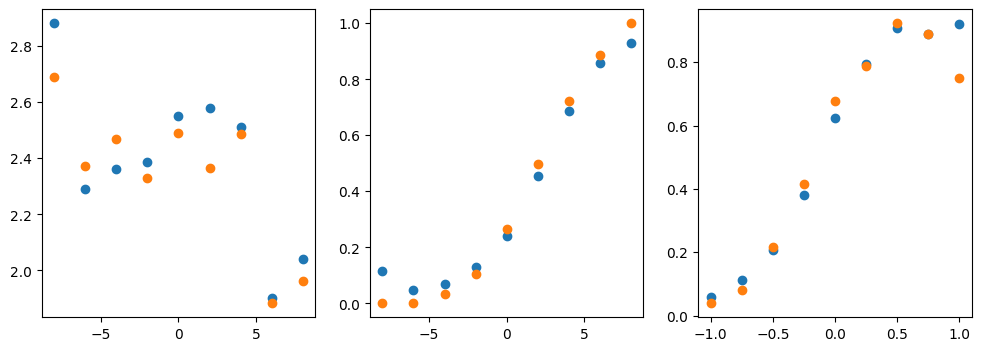

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['choice_2'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - O)')['Dwell Time Advantage (R - O)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - O)')['choice_2'].mean());

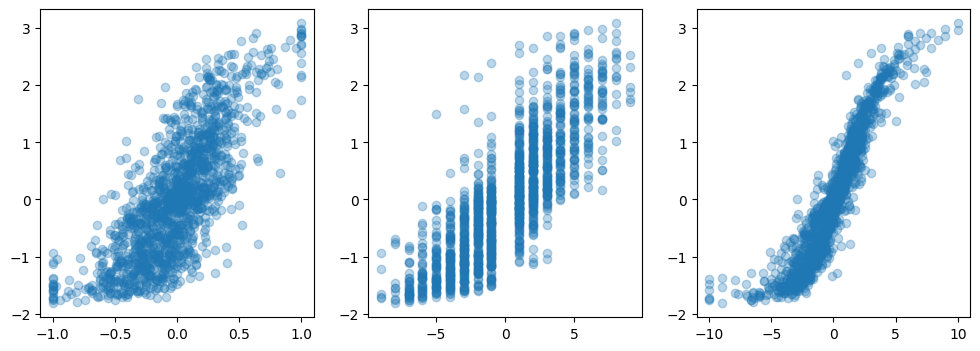

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 1], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 1]*X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

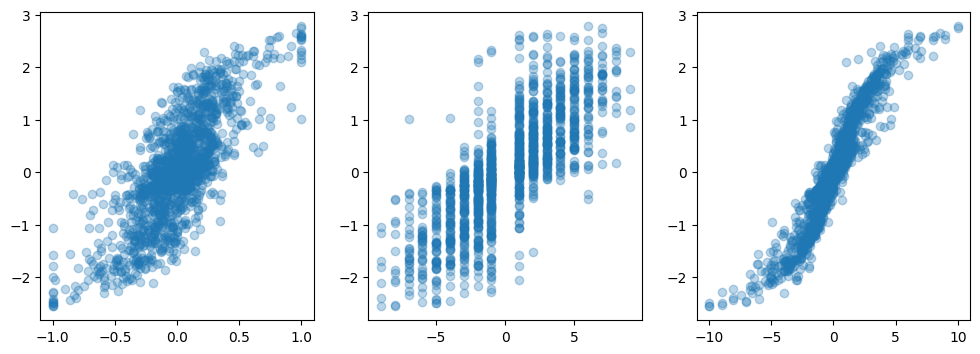

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 0], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 0]*X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);


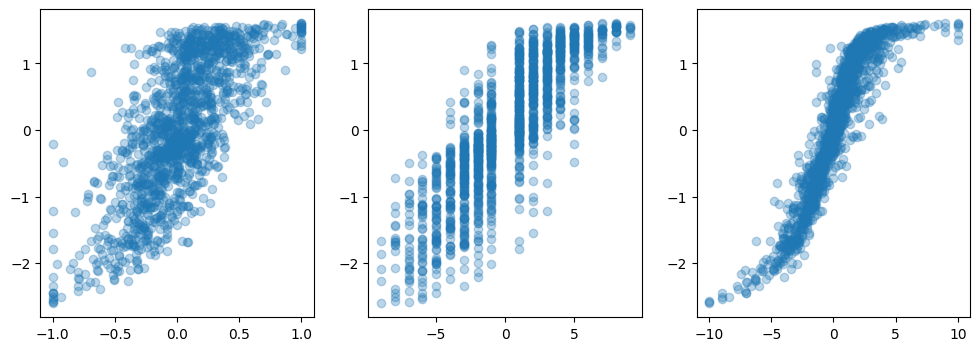

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 4] - X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 1] - X_test[:, 0], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 4] - X_test[:, 0]*X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);